<a href="https://colab.research.google.com/github/LaviWhite/Story-Annotation/blob/main/Sentiment_analysis/sentiment_analysis_Bert_(pythorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 88.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

from transformers import BertConfig, BertForSequenceClassification, BertTokenizer, AdamW, BertModel

from sklearn.model_selection import train_test_split

In [ ]:
import warnings
warnings.filterwarnings('ignore')
path_prefix = './'

# Define Training

In [ ]:

def load_data(data, label=True):

    if label:

        return list(data['content']), [y for y in data['label']]

    return list(data['content'])


class CommentDataset(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.label = y

    def __getitem__(self, idx):
        if self.label is None:
            return self.data[idx]
        return self.data[idx], self.label[idx]

    def __len__(self):
        return len(self.data)

def convert_text_to_ids(tokenizer, text, max_len=200):
    if isinstance(text, str):
        tokenized_text = tokenizer.encode_plus(text, max_length=max_len, truncation=True, add_special_tokens=True)
        input_ids = tokenized_text["input_ids"]
        token_type_ids = tokenized_text["token_type_ids"]
    else:
        input_ids = []
        token_type_ids = []
        for t in text:
            tokenized_text = tokenizer.encode_plus(t, max_length=max_len, truncation=True, add_special_tokens=True)
            input_ids.append(tokenized_text["input_ids"])
            token_type_ids.append(tokenized_text["token_type_ids"])
    return input_ids, token_type_ids


def seq_padding(tokenizer, sentences):
    pad_id = tokenizer.convert_tokens_to_ids("[PAD]")
    if len(sentences) <= 1:
        return torch.tensor(sentences)
    L = [len(sen) for sen in sentences]
    ML = max(L)
    sentences = torch.Tensor([sen + [pad_id] * (ML - len(sen)) if len(sen) < ML else sen for sen in sentences])

    return sentences


# ### 2、Train
def bert_training(batch_size, n_epoch, lr, train, valid, model, tokenizer, model_dir, device):

    train_loss = []
    valid_loss = []
    train_accs = []
    valid_accs = []
    criterion = nn.BCELoss()

    model.train()
    t_batch = len(train)
    v_batch = len(valid)

    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
            {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
            {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = optim.Adam(optimizer_grouped_parameters, lr=lr)

    best_acc = 0

    for epoch in range(n_epoch):
        total_loss, total_acc = 0, 0
        for i, (inputs, labels) in enumerate(train):
            input_ids, token_type_ids = convert_text_to_ids(tokenizer, inputs)
            input_ids = seq_padding(tokenizer, input_ids)
            token_type_ids = seq_padding(tokenizer, token_type_ids)
            labels = labels.squeeze()
            input_ids, token_type_ids, labels = input_ids.long(), token_type_ids.long(), labels.long()
            input_ids, token_type_ids, labels = input_ids.to(device), token_type_ids.to(device), labels.to(device)
            optimizer.zero_grad()

            output = model(input_ids=input_ids, token_type_ids=token_type_ids, labels=labels)
            y_pred_prob = output[1]
            y_pred_labels = y_pred_prob.argmax(dim=1)

            loss = output[0]
            loss.backward()
            optimizer.step()

            correct =((y_pred_labels == labels.view(-1)).sum()).item()
            total_acc += (correct / batch_size)
            total_loss += loss.item()
        print('[ Epoch{} ]: \nTrain | Loss:{:.5f} Acc: {:.3f}'.format(epoch+1, total_loss/t_batch, total_acc/t_batch*100))

        train_loss.append(total_loss/t_batch)
        train_accs.append(total_acc/t_batch)

        model.eval()
        with torch.no_grad():
            total_loss, total_acc = 0, 0
            for i, (inputs, labels) in enumerate(valid):
                input_ids, token_type_ids = convert_text_to_ids(tokenizer, inputs)
                input_ids = seq_padding(tokenizer, input_ids)
                token_type_ids = seq_padding(tokenizer, token_type_ids)
                labels = labels.squeeze()
                input_ids, token_type_ids, labels = input_ids.long(), token_type_ids.long(), labels.long()
                input_ids, token_type_ids, labels = input_ids.to(device), token_type_ids.to(device), labels.to(device)
                output = model(input_ids=input_ids, token_type_ids=token_type_ids, labels=labels)
                y_pred_prob = output[1]
                y_pred_labels = y_pred_prob.argmax(dim=1).squeeze()

                loss = output[0]
                correct = ((y_pred_labels == labels.view(-1)).sum()).item()
                total_acc += (correct / batch_size)
                total_loss += loss.item()

            print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(total_loss/v_batch, total_acc/v_batch*100))
            valid_loss.append(total_loss/v_batch)
            valid_accs.append(total_acc/v_batch)

            if total_acc > best_acc:
                best_acc = total_acc
                torch.save(model, "{}/ckpt.model".format(model_dir))
                print('saving model with acc {:.3f}'.format(total_acc/v_batch*100))

        print('-----------------------------------------------')

        model.train()

    return train_loss, train_accs, valid_loss, valid_accs




Some weights of the model checkpoint at hfl/chinese-bert-wwm-ext were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkp

[ Epoch1 ]: 
Train | Loss:0.51438 Acc: 77.632
Valid | Loss:0.33667 Acc: 84.135 
saving model with acc 84.135
-----------------------------------------------
[ Epoch2 ]: 
Train | Loss:0.41438 Acc: 83.388
Valid | Loss:0.33834 Acc: 84.615 
saving model with acc 84.615
-----------------------------------------------
[ Epoch3 ]: 
Train | Loss:0.46185 Acc: 82.237
Valid | Loss:0.39693 Acc: 81.731 
-----------------------------------------------
[ Epoch4 ]: 
Train | Loss:0.54701 Acc: 77.467
Valid | Loss:0.39102 Acc: 81.250 
-----------------------------------------------
[ Epoch5 ]: 
Train | Loss:0.75395 Acc: 64.803
Valid | Loss:0.70278 Acc: 62.500 
-----------------------------------------------
[ Epoch6 ]: 
Train | Loss:0.68920 Acc: 61.513
Valid | Loss:0.64654 Acc: 62.500 
-----------------------------------------------
[ Epoch7 ]: 
Train | Loss:0.49792 Acc: 80.921
Valid | Loss:0.99688 Acc: 62.500 
-----------------------------------------------
[ Epoch8 ]: 
Train | Loss:0.44413 Acc: 82.072


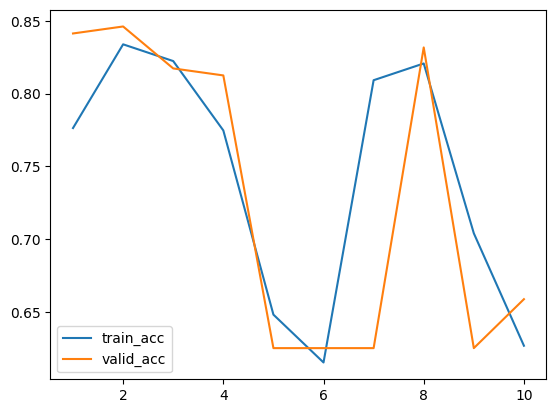

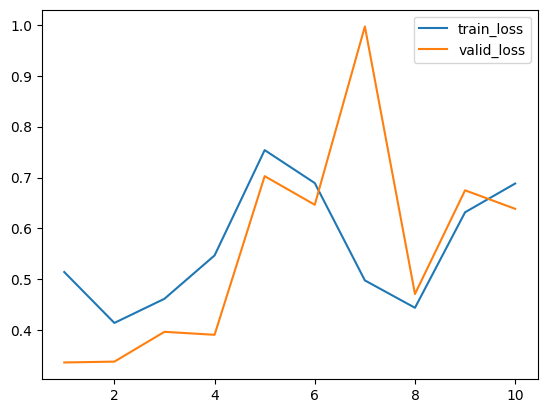

In [ ]:
model_dir = path_prefix

batch_size = 16
epoch = 10
lr = 0.0001
weight_decay = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


train_data = pd.read_excel('/content/drive/MyDrive/Dissertation/pytorch_sentiment_anlysis_1000.xlsx', index_col= 'index')

train, test = train_test_split(train_data, test_size = 0.2, random_state = 2)

train_x, train_y = load_data(train)

X_train, X_val, y_train, y_val = train_test_split(train_x, train_y , test_size = 0.25, random_state = 1)

train_dataset = CommentDataset(X=X_train, y=y_train)
val_dataset = CommentDataset(X=X_val, y=y_val)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                      batch_size = batch_size,
                      shuffle = True,
                      num_workers = 8)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                     batch_size = batch_size,
                     shuffle = False,
                     num_workers = 8)

config = BertConfig.from_pretrained("hfl/chinese-bert-wwm-ext", num_labels=3)
model = BertForSequenceClassification.from_pretrained("hfl/chinese-bert-wwm-ext", config = config)
model.to(device)
tokenizer = BertTokenizer.from_pretrained('hfl/chinese-bert-wwm-ext')

train_loss, train_accs, valid_loss, valid_accs = bert_training(batch_size, epoch, lr, train_loader, val_loader, model, tokenizer, model_dir, device)

fig = plt.figure()
plt.plot(list(range(1, 1+epoch)), train_accs, label='train_acc')
plt.plot(list(range(1, 1+epoch)), valid_accs, label='valid_acc')
plt.legend()
plt.show()

fig = plt.figure()
plt.plot(list(range(1, 1+epoch)), train_loss, label='train_loss')
plt.plot(list(range(1, 1+epoch)), valid_loss, label='valid_loss')
plt.legend()
plt.show()

# Define Testing

In [ ]:

class CommentDataset(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.label = y

    def __getitem__(self, idx):
        if self.label is None:
            return self.data[idx]
        return self.data[idx], self.label[idx]

    def __len__(self):
        return len(self.data)


def convert_text_to_ids(tokenizer, text, max_len=200):
    if isinstance(text, str):
        tokenized_text = tokenizer.encode_plus(text, max_length=max_len, truncation=True, add_special_tokens=True)
        input_ids = tokenized_text["input_ids"]
        token_type_ids = tokenized_text["token_type_ids"]
    else:
        input_ids = []
        token_type_ids = []
        for t in text:
            tokenized_text = tokenizer.encode_plus(t, max_length=max_len, truncation=True, add_special_tokens=True)
            input_ids.append(tokenized_text["input_ids"])
            token_type_ids.append(tokenized_text["token_type_ids"])
    return input_ids, token_type_ids


def seq_padding(tokenizer, sentences):
    pad_id = tokenizer.convert_tokens_to_ids("[PAD]")
    if len(sentences) <= 1:
        return torch.tensor(sentences)

    L = [len(sen) for sen in sentences]
    ML = max(L)
    sentences = torch.Tensor([sen + [pad_id] * (ML - len(sen)) if len(sen) < ML else sen for sen in sentences])

    return sentences


def testing(batch_size, test_loader, model, device):
    model.eval()
    ret_output = []
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            input_ids, token_type_ids = convert_text_to_ids(tokenizer, inputs)
            input_ids = seq_padding(tokenizer, input_ids)
            token_type_ids = seq_padding(tokenizer, token_type_ids)
            input_ids, token_type_ids = input_ids.long(), token_type_ids.long()
            input_ids, token_type_ids = input_ids.to(device), token_type_ids.to(device)

            output = model(input_ids=input_ids, token_type_ids=token_type_ids)
            y_pred_prob = output[0]
            y_pred_labels = y_pred_prob.argmax(dim=1).squeeze()

            ret_temp = [y for y in y_pred_labels.int().tolist()]
            ret_output += ret_temp

    return ret_output



In [ ]:
y_true = test['label']
x_test = test[['content']]


In [ ]:

batch_size = 16
epoch = 10
lr = 0.0001
weight_decay = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_x = load_data(x_test, label = False)
test_dataset = CommentDataset(X=test_x, y=None)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                      batch_size = batch_size,
                      shuffle = False,
                      num_workers = 8)

config = BertConfig.from_pretrained("hfl/chinese-bert-wwm-ext", num_labels=2)
model = BertForSequenceClassification.from_pretrained("hfl/chinese-bert-wwm-ext", config = config)
model.to(device)
tokenizer = BertTokenizer.from_pretrained('hfl/chinese-bert-wwm-ext')

model = torch.load(os.path.join(model_dir, '/content/ckpt.model'))
outputs = testing(batch_size, test_loader, model, device)

tmp = pd.DataFrame({"id":[str(i) for i in range(len(test_x))],"value":outputs})
tmp.to_csv('/content/drive/My Drive/Dissertation/Dissertation_predict_bert_sentiment_analysis.csv', index=False)

Some weights of the model checkpoint at hfl/chinese-bert-wwm-ext were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkp

In [ ]:
tmp.head()

,id,value
0,0,2
1,1,1
2,2,2
3,3,0
4,4,1


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, tmp['value']))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        52
           1       0.98      0.74      0.85        82
           2       0.75      1.00      0.86        66

    accuracy                           0.89       200
   macro avg       0.91      0.90      0.89       200
weighted avg       0.91      0.89      0.89       200

